# Recsys Twitter Challenge

### CONTENIDO
1. Leer dataset
2. Tweet analysis
3. Data cleaning
4. Análisis estadístico
5. Recommender
6. ...
7. Profit

## 1. Leer dataset

In [58]:
# Librerías usadas
import pandas as pd
import numpy as np
import random 
import re
import sys
from transformers import BertTokenizer
from datetime import datetime

Al tener un dataset demasiado grande, hemos creado varios archivos con muestras random del dataset original mediante el siguiente código:


In [24]:
# Muestra random de un archivo .tsv muy grande 
filename = 'training.tsv'
n = 300000000 # tamaño "total"
s = 1000000 # tamaño muestra
#skip = sorted(random.sample(range(1,n+1),n-s)) # filas a saltar

# print(skip)
# DESCOMENTAR SOLO PARA OBTENER NUEVAS MUESTRAS
# df = pd.read_csv(filename, skiprows=skip, delimiter='\x01', header=None)

# Definir columnas
all_features = ["text_tokens", "hashtags", "tweet_id", "present_media", "present_links", "present_domains",\
                "tweet_type","language", "tweet_timestamp", "engaged_with_user_id", "engaged_with_user_follower_count",\
               "engaged_with_user_following_count", "engaged_with_user_is_verified", "engaged_with_user_account_creation",\
               "engaging_user_id", "engaging_user_follower_count", "engaging_user_following_count", "engaging_user_is_verified",\
               "engaging_user_account_creation", "engagee_follows_engager","reply_timestamp","retweet_timestamp","retweet_with_comment_timestamp","like_timestamp"]
#df.columns=all_features

# Exportarlo a un csv
export_filename = 'tocho.csv'

# DESCOMENTAR SOLO PARA OBTENER NUEVAS MUESTRAS
# df.to_csv(export_filename, encoding='utf-8')

In [4]:
# Leer e importar a un dataframe
training = pd.read_csv('tocho2.csv', index_col = 0)
# Miramos las primeras filas
training.head(5)

,text_ tokens,hashtags,tweet_id,present_media,present_links,present_domains,tweet_type,language,tweet_timestamp,engaged_with_user_id,...,engaging_user_id,engaging_user_follower_count,engaging_user_following_count,engaging_user_is_verified,engaging_user_account_creation,engagee_follows_engager,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,like_timestamp
0,101\t16493\t12478\t117\t10105\t42370\t76299\t1...,NaN,39024FBE0136E046D1357196BAECFCA6,GIF,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581532200,3BF0702AA3337E076DA5DF54E55117D1,...,000006829BEADA9EEA695CF0C334B426,2,29,False,1568107028,False,NaN,NaN,NaN,NaN
1,101\t56898\t137\t12026\t10216\t39639\t10161\t1...,NaN,885EECCFE319306E00FFFFAC9016DCAC,NaN,NaN,NaN,Retweet,06D61DCBBE938971E1EA0C38BD9B5446,1581460521,4E3EDF6C1B4E654BA3C710B41749E319,...,00003E6CE47A2F6992901FA83F253C68,1148,1038,False,1266187322,False,NaN,NaN,NaN,NaN
2,101\t14924\t16118\t10114\t12888\t15127\t31204\...,3653868A966576CF17D6A9064889BCED\t7A6710E791A1...,AB3ADBBD011F88D10FE7F6C5FDAB214C,Photo,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581087590,8D231385D11566FF0950BE35095670C9,...,000269A50293CC2B1E9C72B287FA624E,515,424,False,1254588643,True,NaN,NaN,NaN,1.581090e+09
3,101\t138\t19826\t10108\t10105\t10635\t10105\t1...,NaN,675D7920EA2FB4869BA767F5122FB115,NaN,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581134845,8366347FF780E359A5F672C08E66BD49,...,0004C10C480EF88F3EED5822149DC93F,4,125,False,1547955941,False,NaN,NaN,NaN,1.581135e+09
4,101\t73714\t117\t11858\t10730\t12603\t11387\t4...,NaN,9D81B887F9DCA4C481762720A980F372,NaN,NaN,NaN,Quote,2996EB2FE8162C076D070A4C8D6532CD,1581384474,4734A195B8EB1306E37E917023D34E4A,...,0007B114B09D17838F76C88A51374017,34,172,False,1561164616,False,NaN,NaN,NaN,NaN


In [5]:
# Observar columnas
training.columns

Index(['text_ tokens', 'hashtags', 'tweet_id', 'present_media',
       'present_links', 'present_domains', 'tweet_type', 'language',
       'tweet_timestamp', 'engaged_with_user_id',
       'engaged_with_user_follower_count', 'engaged_with_user_following_count',
       'engaged_with_user_is_verified', 'engaged_with_user_account_creation',
       'engaging_user_id', 'engaging_user_follower_count',
       'engaging_user_following_count', 'engaging_user_is_verified',
       'engaging_user_account_creation', 'engagee_follows_engager',
       'reply_timestamp', 'retweet_timestamp',
       'retweet_with_comment_timestamp', 'like_timestamp'],
      dtype='object')

## 2. Tweet analysis

Para leer el contenido, usamos la librería transformers y la documentación de 'Huggingface'

In [40]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
df=training
df['text_tokens'] = df['text_ tokens'].str.split('\t')

Veámos cuáles son los tokens usados en esta librería de transformers

In [35]:
nums = [x for x in range(0,100000)]
print(tokenizer.decode(nums))

[PAD] [unused1] [unused2] [unused3] [unused4] [unused5] [unused6] [unused7] [unused8] [unused9] [unused10] [unused11] [unused12] [unused13] [unused14] [unused15] [unused16] [unused17] [unused18] [unused19] [unused20] [unused21] [unused22] [unused23] [unused24] [unused25] [unused26] [unused27] [unused28] [unused29] [unused30] [unused31] [unused32] [unused33] [unused34] [unused35] [unused36] [unused37] [unused38] [unused39] [unused40] [unused41] [unused42] [unused43] [unused44] [unused45] [unused46] [unused47] [unused48] [unused49] [unused50] [unused51] [unused52] [unused53] [unused54] [unused55] [unused56] [unused57] [unused58] [unused59] [unused60] [unused61] [unused62] [unused63] [unused64] [unused65] [unused66] [unused67] [unused68] [unused69] [unused70] [unused71] [unused72] [unused73] [unused74] [unused75] [unused76] [unused77] [unused78] [unused79] [unused80] [unused81] [unused82] [unused83] [unused84] [unused85] [unused86] [unused87] [unused88] [unused89] [unused90] [unused91] [u

In [8]:
#Subset: English language
dd = df[df.language == 'D3164C7FBCF2565DDF915B1B3AEFB1DC'].copy()
dd = dd.reset_index(drop=True)

In [9]:
dd['tweet_type'].value_counts()

TopLevel    99974
Retweet     72282
Quote       18545
Name: tweet_type, dtype: int64

In [10]:
#engagement_user_type = 'engaging_user_id'
engagement_user_type = 'engaged_with_user_id'

In [11]:
tweet_type = 'TopLevel'
d_tweet_type = dd.loc[dd['tweet_type'] == tweet_type]
d_tweet_type[engagement_user_type].value_counts()[:20]

C6758D692A850E4C67B2763B66D1CFA8    659
5FF622786FB4924A067BD44D4B717570    509
E5D1B83B0E02FAFF871EEEF276D18132    395
7C03844E8B2E0C7B4346D41028AB14E2    328
FBB188A3C1E05C41587AAAC00B5B1879    232
F2A8BF0F4EB185E6D2E5E1A0DF4C33AE    204
416B919C0DAA48D42FF6780574034149    189
8A800256378089EF53C6F655F8690490    183
A9DAB08351D94BDE86235B37D6E8C61D    182
9D9C2BC354011249F2D4D9B9C4205AC9    168
AE7F3DA35832DD67B71D74467CC355C4    166
19E38BE27BE3C55DB1D7B256A9C95576    159
6866DBF67EEF238FC104B49C70A6FBA8    158
4F0721594E4D39E2ABB544EB952BCCF3    156
54F4098AD6C3E94A524C1CFFE68E04E1    146
62BDF6115A75E53FAB212D6A2A41AD9F    144
AD741205F6BAD7FFC0210BCA566C4BA5    141
8B95626DCE50B9ECD10315EB3BD819DF    131
BBA6EAA7EF77AD86EB62B8EA4D153710    128
B6D2643B021752A409EAD1BE66558700    127
Name: engaged_with_user_id, dtype: int64

In [12]:
engaging_user_id = 'FBB188A3C1E05C41587AAAC00B5B1879'
dd_user = d_tweet_type.loc[dd[engagement_user_type] == engaging_user_id]

for index, row in dd_user.iterrows():    
    print(tokenizer.decode(d_tweet_type['text_ tokens'][index]))

[CLS] Sen. Susan Collins has become the first Republican senator to break rank and announce support for witnesses and documents in the impeachment trial of President Trump. https : / / t. co / GI4wEFOiyQ [SEP]
[CLS] The Trump administration is expected to announce an expansion of the travel ban, a revision of one of Trump's signature policies, which was derided by critics as an attempt to ban Muslims from the US, according to sources familiar with the restrictions. https : / / t. co / SmOpEmi7ea [SEP]
[CLS] The Virginia House of Delegates passed seven pieces of gun safety legislation, signaling its dedication to the gun control priorities it set heading into the 2020 legislative session https : / / t. co / wG69biIyri [SEP]
[CLS] An Indiana man is being honored after a distressed parent left a newborn child in a baby drop - off box he raised money to install https : / / t. co / RSDeQUrgNH [SEP]
[CLS] At least 29 people died and more than 1, 400 are injured in eastern Turkey after an ear

In [13]:
engaging_user_id = 'FBB188A3C1E05C41587AAAC00B5B1879'
dd_user = d_tweet_type.loc[dd[engagement_user_type] == engaging_user_id]
list_twits = []
valid_pattern = 'https : \/ \/ t\. co \/ [\dA-Za-z\.-]+'

for index, row in dd_user.iterrows():
    list_twits.append(re.findall(valid_pattern, tokenizer.decode(dd['text_ tokens'][index])))
    
    #print(tokenizer.decode(d_tweet_type['text_ tokens'][index]))
    
for i, s in enumerate(list_twits):
    list_twits_item = []
    for item in list_twits[i]:
        list_twits_item.append(item.replace(' ','')) # I use replace because s.strip() is not working 
        print(list_twits_item)
#print(list_twits)

['https://t.co/GI4wEFOiyQ']
['https://t.co/SmOpEmi7ea']
['https://t.co/wG69biIyri']
['https://t.co/RSDeQUrgNH']
['https://t.co/V8794IlcJg']
['https://t.co/0chtYXRsok']
['https://t.co/iTuozN0GJJ']
['https://t.co/5TELoGyZtT']
['https://t.co/aHVUMJioQv']
['https://t.co/aHVUMJioQv', 'https://t.co/u2ljckZExm']
['https://t.co/xMpKWYaeIv']
['https://t.co/xMpKWYaeIv', 'https://t.co/pokpvM10ls']
['https://t.co/4UZrT3qIZ4']
['https://t.co/4UZrT3qIZ4', 'https://t.co/BWb7srgeEI']
['https://t.co/fo2jeGgrDj']
['https://t.co/0QoI1IAX6H']
['https://t.co/0QoI1IAX6H', 'https://t.co/ApFDZz2c2y']
['https://t.co/46a2llLi1W']
['https://t.co/RSDeQUrgNH']
['https://t.co/dzY1VocTsK']
['https://t.co/ArWkbWUGbD']
['https://t.co/ORRpQE6k4w']
['https://t.co/ORRpQE6k4w', 'https://t.co/MZiIFxq9BZ']
['https://t.co/sFTqIuENZx']
['https://t.co/zOoou3AAmN']
['https://t.co/zOoou3AAmN', 'https://t.co/aMGAqKnQPN']
['https://t.co/ouaqox4sTs']
['https://t.co/P8pFIXKdez']
['https://t.co/L2pfAexGj0']
['https://t.co/KTzabIrDEk'

In [14]:
#CNN ID: FBB188A3C1E05C41587AAAC00B5B1879

## 3. Data Cleaning

Iremos columna a columna mirando como podemos limpiar los datos o estrucurarlos de formas distintas para ayudar a futuros análisis.

In [15]:
training['present_media'].value_counts(dropna=False)

NaN                           282557
Photo                          84168
Video                          49106
Photo\tPhoto                   18320
Photo\tPhoto\tPhoto\tPhoto     10561
Photo\tPhoto\tPhoto             5898
GIF                             4903
Video\tVideo                       2
Photo\tVideo                       2
Video\tPhoto                       1
Name: present_media, dtype: int64

In [16]:
#First, we will split them into a list
training['present_media'] = training['present_media'].str.split('\t')

In [17]:
#Now, let's do a one hot encoding
def hot_encod_photo(x):
    try:
        return x.count('Photo')
    except AttributeError:
        return 0
def hot_encod_video(x):
    try:
        return x.count('Video')
    except AttributeError:
        return 0
def hot_encod_gif(x):
    try:
        return x.count('GIF')
    except AttributeError:
        return 0

training['photo'] = training['present_media'].apply(hot_encod_photo)
training['video'] = training['present_media'].apply(hot_encod_video)
training['gif'] = training['present_media'].apply(hot_encod_gif)

training.drop(['present_media'], axis=1, inplace=True)

In [18]:
training['present_links'].value_counts(dropna=False)

NaN                                 391545
E522B6C629B01DA6B29DE65BF5DFA55B       124
140BCA0056E50C79778369C95D6DDC63        52
270B33AB02B6FB3F60B748CF1CB9AB75        42
DEA673FD63DDDC8A3606106D5CA235B0        38
                                     ...  
714CBD5F6E9563CAB3C2FC033CA79D67         1
1AE0316E1D6CC269C257F0D6B73D346D         1
7EAAF63CB1916ABF6A5DEDF6BDABACA0         1
1941922B8E4CF207A8E9C448C3B3C76C         1
984EB2BB22B104C155508067044276AD         1
Name: present_links, Length: 55355, dtype: int64

In [19]:
training['link_exists'] = pd.isnull(training['present_links'])

In [20]:
training['hashtags'].value_counts(dropna=False)

NaN                                                                                                                                                                                                           364456
5671B8B6E92C2A316C05A7CD2F17366C                                                                                                                                                                                 949
18F6AC96A6EA62716A47DE9FE6241534                                                                                                                                                                                 546
31C316EB7BB8CD1778CB83B8AA2603D9                                                                                                                                                                                 296
B6024D6F02AFAF9BC8ED941F72C228F1                                                                                                                    

In [105]:
training['tweet_id'].value_counts()

00BBF1FA06AFB29C7E17BE89BCEF028F    92
92A744FDE0BF53B06DC20BC1AA826A4C    69
7A38C8C1E94B639B7AD464755EF1A6AB    44
23C719ED85B8CC4BB017AD5A2901D758    42
7BDBCE51855573CAAFA177C8CB2FC67A    42
                                    ..
AA9BE1D329E2FD92A3584368B2FA0033     1
94ED71D8C73D8F92AA735EB1C630EEB0     1
481CEB6522BE166DC933088EB09506AF     1
CEE9749FA5543C71F8D50DD95FAB5AB8     1
6CB94F7A089EA7FC824853F18A01B113     1
Name: tweet_id, Length: 425996, dtype: int64

In [21]:
training['categorical_type'] = pd.Categorical(training['tweet_type'])
dfDummies = pd.get_dummies(training['categorical_type'], prefix = 'engagement_type')
training=pd.concat([training, dfDummies], axis=1)
training.drop(['categorical_type','tweet_type'], axis=1,inplace=True)

In [22]:
# Tenemos 3 columnas de Timestamps (a veces en más de una columna o NaNs), 
# nos quedamos solo con el más temprano y clasificamos los falsos positivos
training['engagement_timestamp'] = training[['reply_timestamp','retweet_with_comment_timestamp','like_timestamp']].min(axis=1)
training.drop(['reply_timestamp','retweet_with_comment_timestamp','like_timestamp'], axis=1, inplace=True)

# Creamos una columna con un 0 con no engagement y un 1 con egagement
training['engagement_exists']=training['engagement_timestamp'].apply(lambda x: 0 if (np.isnan(x)) else 1)

## Timestamp


In [59]:
training['tweet_timestamp'] = [datetime.fromtimestamp(x) for x in training['tweet_timestamp']]
training['tweet_timestamp'] = [datetime.fromtimestamp(x) for x in training['tweet_timestamp']]
training['tweet_timestamp'] = [datetime.fromtimestamp(x) for x in training['tweet_timestamp']]

training['tweet_timestamp'].head(5)

TypeError: an integer is required (got type Timestamp)

In [60]:
training['tweet_timestamp_day']=training['tweet_timestamp'].dt.weekday
# 0 Lunes, 1 Martes... 6 Domingo
training['tweet_timestamp_day'].head(5)

0    2
1    1
2    4
3    5
4    1
Name: tweet_timestamp_day, dtype: int64

In [54]:
train = training[training['tweet_timestamp_day']<5]
test = training[training['tweet_timestamp_day']>4]

## Interrogants

In [44]:
df['text_ tokens'].head(5)

0    [101, 16493, 12478, 117, 10105, 42370, 76299, ...
1    [101, 56898, 137, 12026, 10216, 39639, 10161, ...
2    [101, 14924, 16118, 10114, 12888, 15127, 31204...
3    [101, 138, 19826, 10108, 10105, 10635, 10105, ...
4    [101, 73714, 117, 11858, 10730, 12603, 11387, ...
Name: text_ tokens, dtype: object

In [52]:
df['question'] = df['text_ tokens'].apply(lambda x: '136' in x)
df['question'].value_counts()

False    424076
True      31442
Name: question, dtype: int64

## Followers/Following

In [61]:
df.columns

Index(['text_ tokens', 'hashtags', 'tweet_id', 'present_links',
       'present_domains', 'language', 'tweet_timestamp',
       'engaged_with_user_id', 'engaged_with_user_follower_count',
       'engaged_with_user_following_count', 'engaged_with_user_is_verified',
       'engaged_with_user_account_creation', 'engaging_user_id',
       'engaging_user_follower_count', 'engaging_user_following_count',
       'engaging_user_is_verified', 'engaging_user_account_creation',
       'engagee_follows_engager', 'retweet_timestamp', 'photo', 'video', 'gif',
       'link_exists', 'engagement_type_Quote', 'engagement_type_Retweet',
       'engagement_type_TopLevel', 'engagement_timestamp', 'engagement_exists',
       'tweet_timestamp_day', 'text_tokens', 'question'],
      dtype='object')

In [65]:
df['engaged_followers_ratio']=df['engaged_with_user_follower_count']/df['engaged_with_user_following_count']
df['engaging_followers_ratio']=df['engaging_user_follower_count']/df['engaging_user_following_count']

## Proves xgboost

In [66]:
import xgboost as xgb

In [67]:
df.columns

Index(['text_ tokens', 'hashtags', 'tweet_id', 'present_links',
       'present_domains', 'language', 'tweet_timestamp',
       'engaged_with_user_id', 'engaged_with_user_follower_count',
       'engaged_with_user_following_count', 'engaged_with_user_is_verified',
       'engaged_with_user_account_creation', 'engaging_user_id',
       'engaging_user_follower_count', 'engaging_user_following_count',
       'engaging_user_is_verified', 'engaging_user_account_creation',
       'engagee_follows_engager', 'retweet_timestamp', 'photo', 'video', 'gif',
       'link_exists', 'engagement_type_Quote', 'engagement_type_Retweet',
       'engagement_type_TopLevel', 'engagement_timestamp', 'engagement_exists',
       'tweet_timestamp_day', 'text_tokens', 'question',
       'engaged_followers_ratio', 'engaging_followers_ratio'],
      dtype='object')

In [98]:
features = ['text_tokens','engaged_with_user_is_verified', 'engagee_follows_engager', 'photo', 'video', 'gif',
       'link_exists']

In [99]:
train = df[df['tweet_timestamp_day']<5]
test = df[df['tweet_timestamp_day']>4]
X_train=train[features]
y_train=train['engagement_exists']
X_test=test[features]
y_test=test['engagement_exists']

In [100]:
xg_rec = xgb.XGBClassifier()

In [101]:
xg_rec.fit(X_train,y_train)
preds = xg_rec.predict(X_test)

In [102]:
from sklearn.metrics import classification_report, plot_confusion_matrix

target_names = ['no engagement', 'engagement']
print(classification_report(y_test, preds, target_names=target_names))


               precision    recall  f1-score   support

no engagement       0.55      0.82      0.66     71221
   engagement       0.58      0.28      0.38     64730

     accuracy                           0.56    135951
    macro avg       0.57      0.55      0.52    135951
 weighted avg       0.57      0.56      0.53    135951



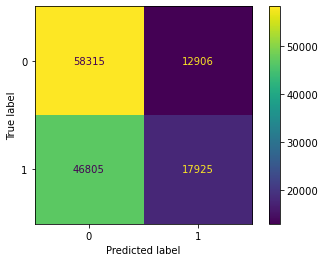

In [103]:
plot_confusion_matrix(xg_rec, X_test, y_test) 
